# Hyperparameter Tuning

In [164]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe

import warnings
# To avoid a `optional dependency `torch` is not available` warning with tpot
warnings.simplefilter('ignore')
from tpot import TPOTClassifier

In [90]:
df = pd.read_csv("data/titantic-train.csv")
df = df[["Fare", "Age", "Pclass", "SibSp", "Parch", "Survived"]].dropna()

X = df.iloc[:, :-1]
y = df.iloc[:, -1:].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

## Basic Fitting and Scoring

In [116]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

# score and accuracy_score measure the same metric but in different ways
print("rf.score: {:.2f}".format(rf.score(X_test, y_test)))

y_pred = rf.predict(X_test)
print("accuracy_score: {:.2f}".format(accuracy_score(y_test, y_pred)))

print("cross_val_score: {:.2f}".format(cross_val_score(rf, X, y).mean()))

rf.score: 0.67
accuracy_score: 0.67
cross_val_score: 0.68


## Grid Search

In [117]:
rf = RandomForestClassifier(random_state=1)
param_grid = {
    'n_estimators': np.arange(50, 200, 25),
    'max_depth': range(2, 8)
}

rf_cv = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)

print("Bests parameters: {}".format(rf_cv.best_params_)) 
print("Best score: {:.2f}".format(rf_cv.best_score_))
print("Cross val score: {:.2f}".format(cross_val_score(rf_cv, X_test, y_test).mean()))

Bests parameters: {'max_depth': 5, 'n_estimators': 125}
Best score: 0.74
Cross val score: 0.68


### Inspecting grid search results

In [120]:
pd.DataFrame(rf_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.130654,0.001870,0.012664,0.001354,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.682243,0.635514,0.710280,0.700935,0.719626,0.689720,0.029789,34
1,0.200543,0.007618,0.016523,0.001274,2,75,"{'max_depth': 2, 'n_estimators': 75}",0.682243,0.635514,0.710280,0.691589,0.728972,0.689720,0.031500,35
2,0.282160,0.008168,0.022606,0.003857,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.682243,0.644860,0.710280,0.691589,0.728972,0.691589,0.028347,33
3,0.356142,0.012887,0.024831,0.001657,2,125,"{'max_depth': 2, 'n_estimators': 125}",0.672897,0.635514,0.710280,0.691589,0.728972,0.687850,0.032158,36
4,0.449668,0.017736,0.043828,0.009241,2,150,"{'max_depth': 2, 'n_estimators': 150}",0.691589,0.654206,0.710280,0.691589,0.728972,0.695327,0.024797,32
5,0.562337,0.016077,0.030346,0.002007,2,175,"{'max_depth': 2, 'n_estimators': 175}",0.691589,0.644860,0.710280,0.700935,0.728972,0.695327,0.028100,31
6,0.156361,0.023407,0.013681,0.004258,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.719626,0.663551,0.728972,0.738318,0.775701,0.725234,0.036244,30
7,0.187256,0.002807,0.016141,0.002406,3,75,"{'max_depth': 3, 'n_estimators': 75}",0.719626,0.672897,0.728972,0.738318,0.775701,0.727103,0.033122,28
8,0.259037,0.007344,0.019546,0.002810,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.719626,0.663551,0.728972,0.738318,0.785047,0.727103,0.038940,26
9,0.303846,0.015269,0.022308,0.002768,3,125,"{'max_depth': 3, 'n_estimators': 125}",0.719626,0.663551,0.728972,0.738318,0.785047,0.727103,0.038940,26


## Random Search

In [130]:
rf = RandomForestClassifier(random_state=1)
param_grid = {
    'n_estimators': np.arange(50, 500, 25),
    'max_depth': range(2, 20)
}

# n_iter (number of iterations) is the number of sampled combinations of hyperparameters
rf_cv = RandomizedSearchCV(rf, param_grid, random_state=1, n_iter=50, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)

print("Bests parameters: {}".format(rf_cv.best_params_)) 
print("Best score: {:.2f}".format(rf_cv.best_score_))
print("Cross val score: {:.2f}".format(cross_val_score(rf_cv, X_test, y_test).mean()))

Bests parameters: {'n_estimators': 425, 'max_depth': 7}
Best score: 0.74
Cross val score: 0.70


In [122]:
df = pd.DataFrame(rf_cv.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.130268,0.003439,0.011136,0.000766,50,7,"{'n_estimators': 50, 'max_depth': 7}",0.719626,0.644860,0.757009,0.766355,0.757009,0.728972,0.045015,9
1,0.388667,0.002007,0.033691,0.005079,150,7,"{'n_estimators': 150, 'max_depth': 7}",0.719626,0.644860,0.757009,0.785047,0.775701,0.736449,0.050984,4
2,0.382457,0.006916,0.027185,0.001697,150,6,"{'n_estimators': 150, 'max_depth': 6}",0.710280,0.635514,0.747664,0.785047,0.785047,0.732710,0.055950,6
3,0.305021,0.003446,0.021309,0.000973,125,2,"{'n_estimators': 125, 'max_depth': 2}",0.672897,0.635514,0.710280,0.691589,0.728972,0.687850,0.032158,10
4,0.180069,0.006781,0.014556,0.001605,75,5,"{'n_estimators': 75, 'max_depth': 5}",0.728972,0.635514,0.738318,0.785047,0.794393,0.736449,0.056509,5
5,0.423250,0.006835,0.032053,0.004332,175,4,"{'n_estimators': 175, 'max_depth': 4}",0.728972,0.644860,0.728972,0.766355,0.785047,0.730841,0.048165,7
6,0.312617,0.003313,0.023859,0.004497,125,5,"{'n_estimators': 125, 'max_depth': 5}",0.728972,0.644860,0.747664,0.785047,0.803738,0.742056,0.055322,1
7,0.425931,0.009402,0.032333,0.001836,175,5,"{'n_estimators': 175, 'max_depth': 5}",0.710280,0.644860,0.738318,0.757009,0.803738,0.730841,0.052669,7
8,0.413318,0.025789,0.024067,0.006235,175,6,"{'n_estimators': 175, 'max_depth': 6}",0.719626,0.635514,0.757009,0.785047,0.794393,0.738318,0.057611,3
9,0.223631,0.029920,0.014834,0.003641,100,6,"{'n_estimators': 100, 'max_depth': 6}",0.719626,0.644860,0.747664,0.794393,0.785047,0.738318,0.053850,2


### Visualizing distribution of accuracy scores

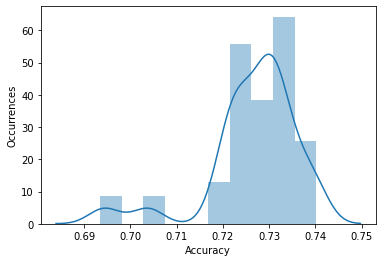

In [136]:
sns.distplot(rf_cv.cv_results_['mean_test_score'], hist=True, kde=True)
plt.xlabel("Accuracy")
plt.ylabel("Occurrences")
plt.show()

### Visualizing the impact of hyperparameter values on accuracy

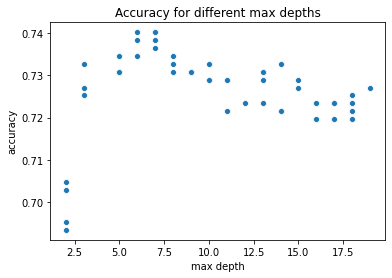

In [137]:
sns.scatterplot(data=rf_cv.cv_results_, x="param_max_depth", y="mean_test_score")
plt.title("Accuracy for different max depths")
plt.xlabel("max depth")
plt.ylabel("accuracy")
plt.show()

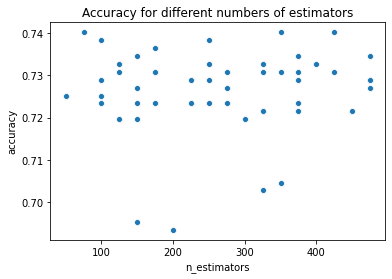

In [139]:
sns.scatterplot(data=rf_cv.cv_results_, x="param_n_estimators", y="mean_test_score")
plt.title("Accuracy for different numbers of estimators")
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.show()

If these scatter plots showed patterns where certain values clearly outperformed others, we could use it to inform a grid search.

## Grid search with named steps

In [104]:
pipeline = Pipeline([('scaler', StandardScaler()), ('SVM', SVC())])
param_grid = {
    'SVM__C': [1, 10, 100],
    'SVM__gamma': [0.1, 0.01]
}
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Bests parameters: {}".format(grid.best_params_)) 
print("Best score: {:.2f}".format(grid.best_score_))
print("Cross val score: {:.2f}".format(cross_val_score(grid, X_test, y_test).mean()))

Bests parameters: {'SVM__C': 100, 'SVM__gamma': 0.01}
Best score: 0.75
Cross val score: 0.65


## Grid search without named steps

In [105]:
pipeline = make_pipeline(StandardScaler(), SVC())
param_grid = {
    "svc__C": [1, 10, 100],
    "svc__gamma": [0.1, 0.01]
}
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Bests parameters: {}".format(grid.best_params_)) 
print("Best score: {:.2f}".format(grid.best_score_))
print("Cross val score: {:.2f}".format(cross_val_score(grid, X_test, y_test).mean()))

Bests parameters: {'svc__C': 100, 'svc__gamma': 0.01}
Best score: 0.75
Cross val score: 0.65


## Bayesian Hyperparameter Tuning

References:

* [Hyperparameter Tuning in Python](https://campus.datacamp.com/courses/hyperparameter-tuning-in-python/informed-search?ex=6)
* [Part 2: Hyperopt.](https://towardsdatascience.com/hyperparameter-optimization-in-python-part-2-hyperopt-5f661db91324)
* [Hyperopt FMin docs](https://github.com/hyperopt/hyperopt/wiki/FMin)

In [160]:
# We need to define two things:

# 1. The search space
space = {
    "max_depth": hp.quniform('max_depth', 2, 8, 2),
    "n_estimators": hp.quniform('n_estimators', 50, 200, 4)
}

# 2. The objective
def objective(params):
    params = {
        "max_depth": int(params["max_depth"]),
        "n_estimators": int(params["n_estimators"])}
    rf = RandomForestClassifier(**params) 
    best_score = cross_val_score(rf, X_train, y_train, scoring="accuracy", cv=2, n_jobs=-1).mean()
    
    # hyperopt minimizes the function, which is why we return the loss and not the best score
    # (lower loss is better)
    loss = 1 - best_score
    return loss

# Then we need to run the optimization function
best = fmin(fn=objective, space=space, max_evals=20, rstate=np.random.RandomState(42), algo=tpe.suggest)
print(best)

100%|██████████| 20/20 [00:08<00:00,  2.34trial/s, best loss: 0.26531667505170775]
{'max_depth': 4.0, 'n_estimators': 172.0}


## Genetic Hyperparameter Tuning with TPOT

References:

* [Hyperparameter Tuning in Python](https://campus.datacamp.com/courses/hyperparameter-tuning-in-python/informed-search)

In [172]:
# "TPOT is quite unstable when only running with low generations, population size and offspring.
# Increasing the generations, population size and offspring and running this for a long 
# time will assist to produce better models and more stable results."
tpot_clf = TPOTClassifier(generations=10, population_size=8, offspring_size=5, 
                            scoring="accuracy", verbosity=2, random_state=2, cv=2)

tpot_clf.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.7197090390742915
Generation 2 - Current best internal CV score: 0.7252920789311867
Generation 3 - Current best internal CV score: 0.7252920789311867
Generation 4 - Current best internal CV score: 0.7252920789311867
Generation 5 - Current best internal CV score: 0.7252920789311867
Generation 6 - Current best internal CV score: 0.7252920789311867
Generation 7 - Current best internal CV score: 0.7290723349544412
Generation 8 - Current best internal CV score: 0.7290723349544412
Generation 9 - Current best internal CV score: 0.7439977080887696
Generation 10 - Current best internal CV score: 0.7439977080887696
Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=100)


TPOTClassifier(cv=2, generations=10,
               log_file=<ipykernel.iostream.OutStream object at 0x1072a9460>,
               offspring_size=5, population_size=8, random_state=2,
               scoring='accuracy', verbosity=2)